In [5]:
import kernel
import pandas as pd
import numpy as np

target_countries = ['Senegal', 'Mauritania', 'Mali', 'Burkina Faso', 'Niger', 'Nigeria', 'Cameroon', 'Chad', 'Central African Republic', 'South Sudan', 'Sudan', 'Eritrea']

dataset = pd.read_csv('datasets/DatasetMonthly.csv')

print(len(dataset[dataset['Political violence']>5]))
print(len(dataset[dataset['Political violence']<=5]))


1193
1831


In [6]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, temporal_train_test_split
from sktime.split import SingleWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sktime.forecasting.base import ForecastingHorizon
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import networkx as nx
from sktime.utils import plot_series
import lingam


def create_forecaster():
    
    regressor = xgb.XGBRegressor()
    forecaster = make_reduction(regressor, window_length=6, strategy='recursive', windows_identical=False)

    return forecaster

country_list = dataset['COUNTRY'].unique()
results = []
results_original = []
window_length = 6


dataset['FATALITIES'] = dataset['FATALITIES'].astype(float)
for country in np.unique(dataset['COUNTRY']):
    for lag in range(1, window_length+1):
        dataset.loc[dataset['COUNTRY']==country, f'FATALITIES_lag{lag}'] = dataset.loc[dataset['COUNTRY']==country, 'FATALITIES'].shift(lag).fillna(0)

df_d1 = dataset[dataset['FATALITIES'] > 5]
df_d2 = dataset[dataset['FATALITIES'] <= 5]
domain_shifter_ab = kernel.train_domain_shifter(df_d2, df_d1)
domain_shifter_ba = kernel.train_domain_shifter(df_d1, df_d2)

Fitting FATALITIES
y_pred is  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [20.638977 20.638977 20.638977 ... 20.638977 20.638977  4.499832]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [40.77793 40.77793 40.77793 ... 40.77793 40.77793  8.49966]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [60.916866 60.916866 60.916866 ... 60.916866 60.916866 12.499484]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [81.0558   81.0558   81.0558   ... 81.0558   81.0558   16.499304]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [101.19474 101.19474 101.19474 ... 101.19474 101.19474  20.49912]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [121.333694 121.333694 121.333694 ... 121.333694 121.333694  24.498934]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [141.47267  141.47267  141.47267  ... 141.47267  141.47267   28.498745]
y_true is  [ 24. 270.  14. ... 135.   7.  72.]
y_pred is  [161.611

187 24
205 6
130 81
194 17
163 48
20 191
149 62
143 68
90 121
0 96


C:\Users\alber\AppData\Local\Temp\ipykernel_18560\2631522462.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_aug = pd.concat([data_aug_ab, data_aug_ba], axis=0).sort_index()


1 210


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sktime\utils\plotting.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))


187 24
[(1.2036896638993948, 1365477227505316.2), (0.5511910014715538, 1993446737264330.8), (54.96343137633126, 0.3692843126382249), (126.43859967420686, 1.012685832046816), (169.0212822365311, 111157035623797.19), (438.54550516380453, 0.948084129235381), (79.80558497950716, 0.6173304921304937), (43.22293420557706, 2978810264991629.5), (109.69739010648907, 4.223861459649669), (169.4385280609131, 1.0699771879860227), (100.46491327825582, 2.0812610667046423), (0.5205008029094282, 2007966062675156.5)]
[(1.3690484909446172, 1818314866816599.2), (0.5246264608115625, 1522565470095785.0), (55.36139196719763, 0.38227691991902907), (126.12919656735546, 0.9845386754385836), (167.98701991787496, 395004495542780.25), (443.13520438716097, 0.9087698673982793), (76.45393918595224, 0.5852782188523362), (53.142537664692355, 3580724804954384.5), (102.52932634893453, 3.841283301173247), (194.7134288152059, 1.0594043912118545), (121.71493890150538, 2.904713215787968), (0.7855650963050858, 2892748374043203

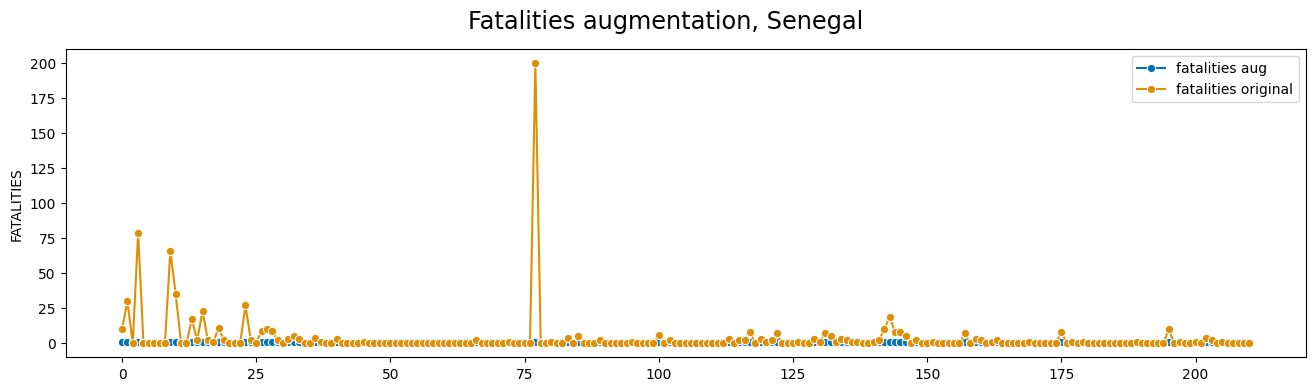

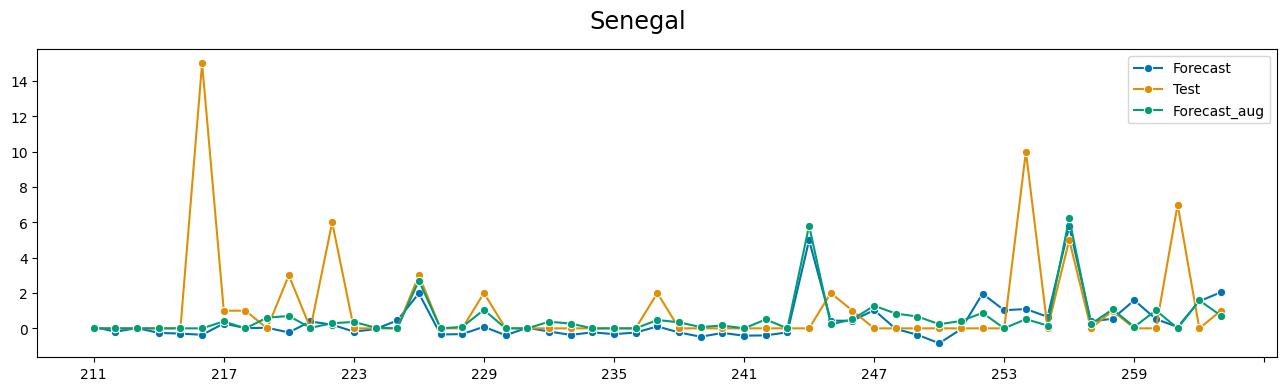

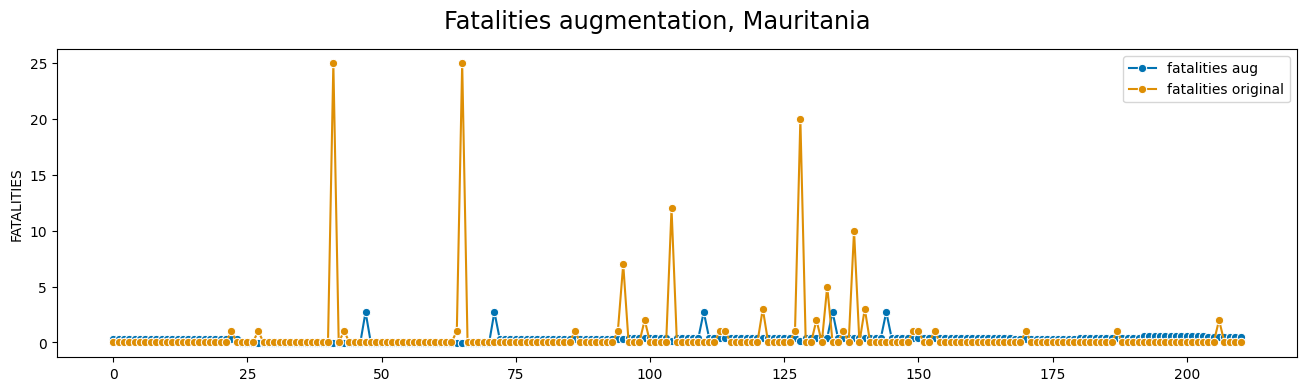

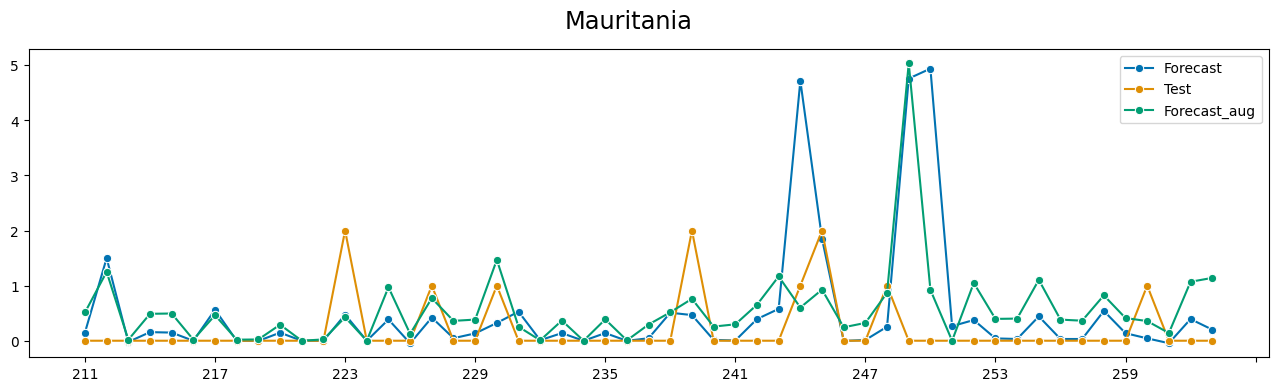

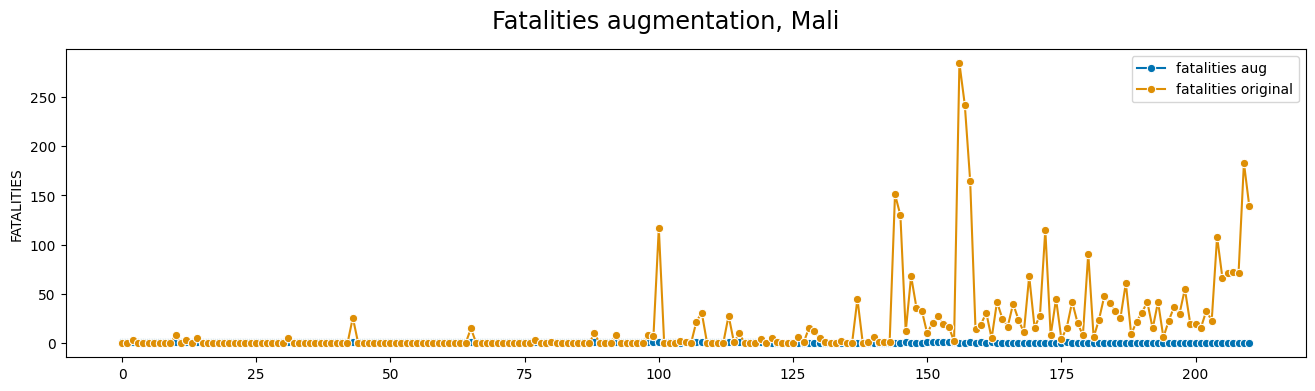

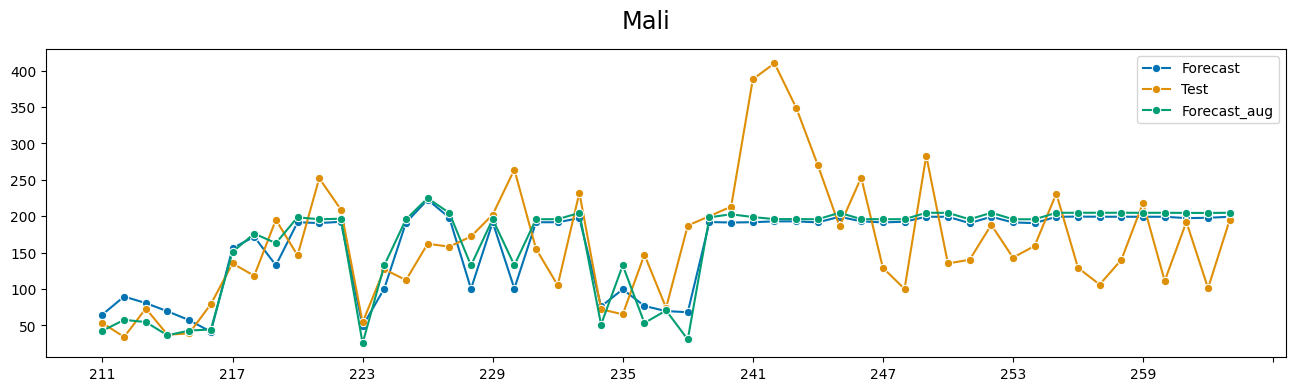

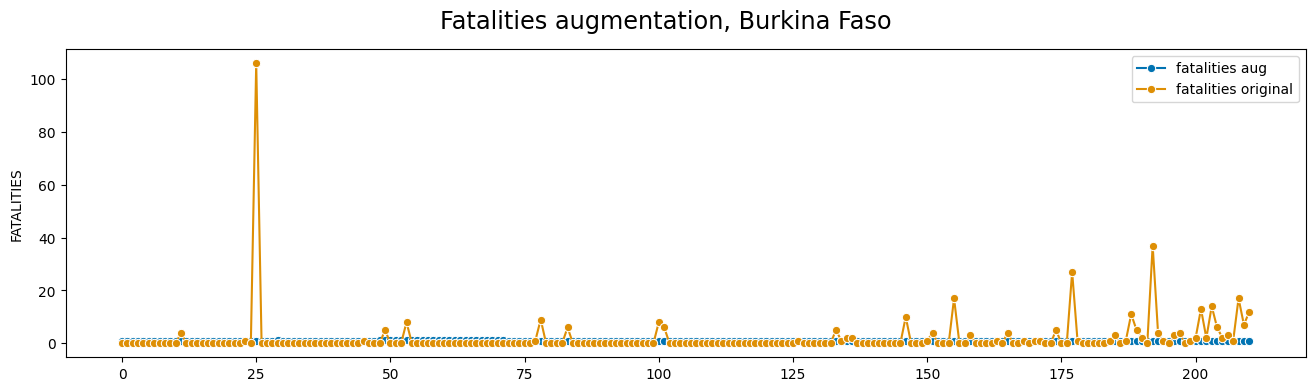

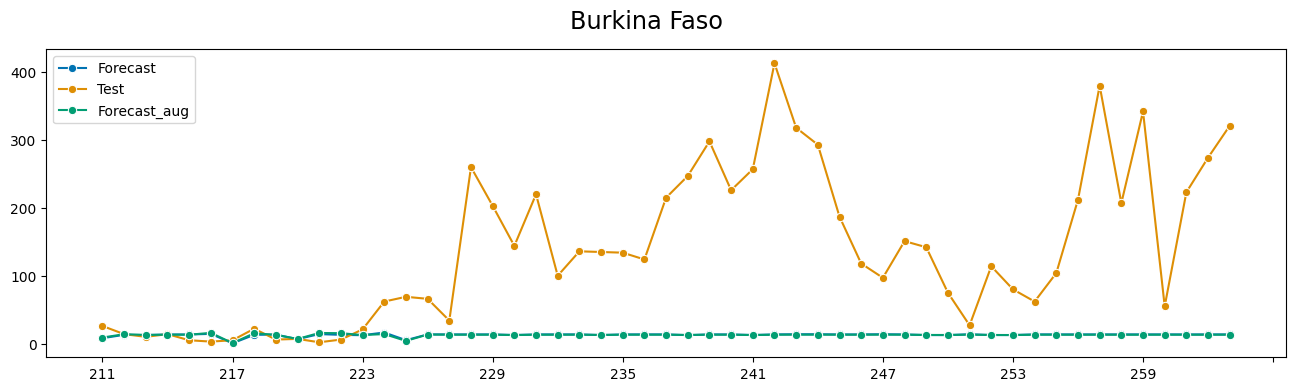

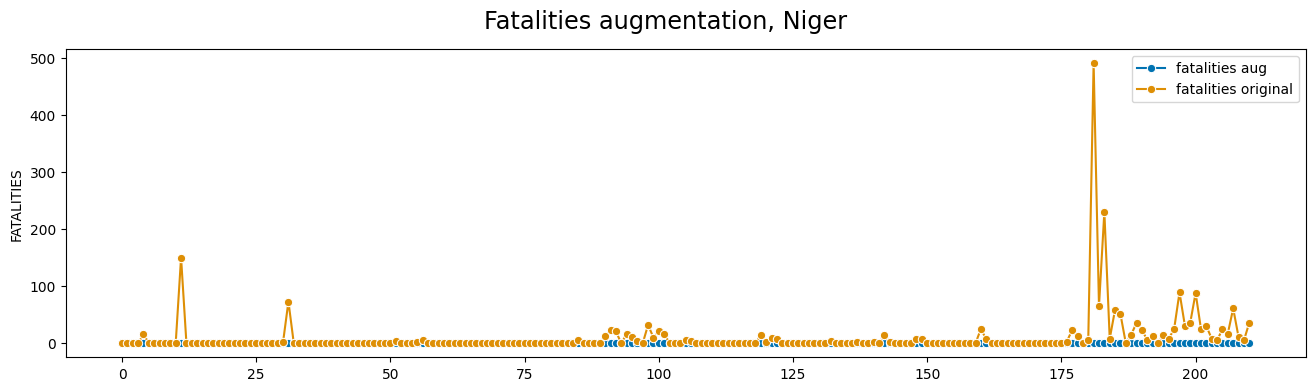

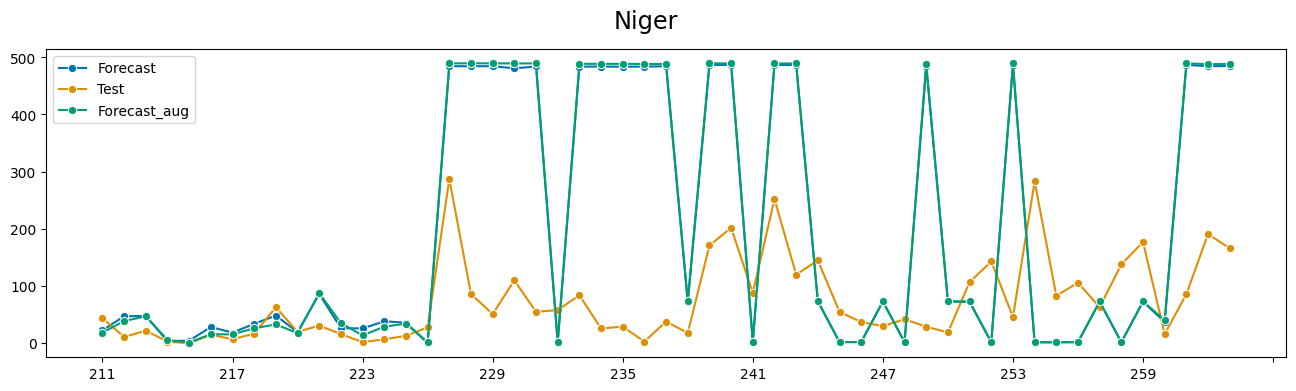

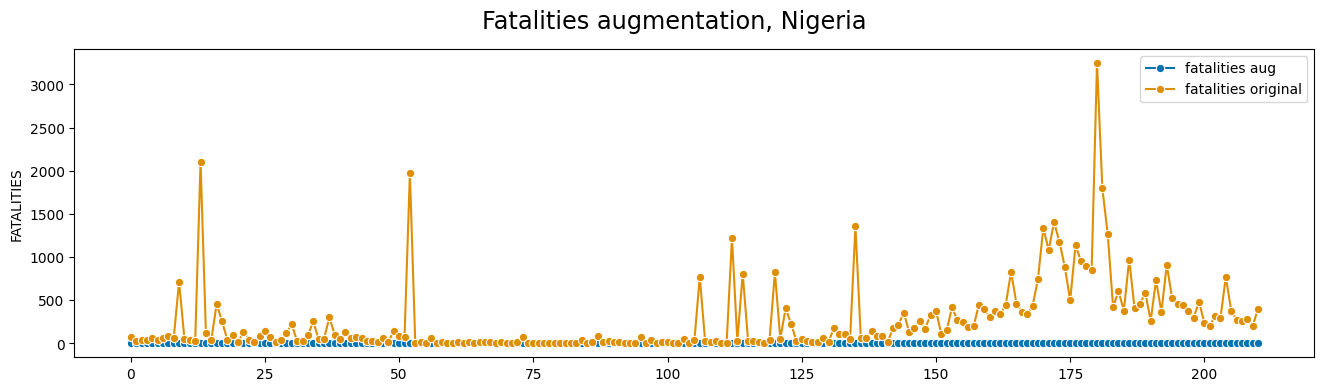

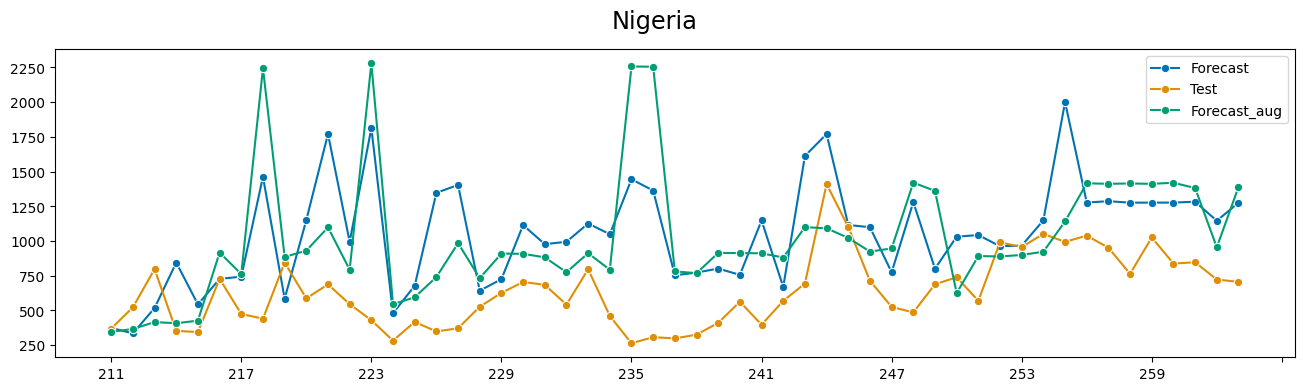

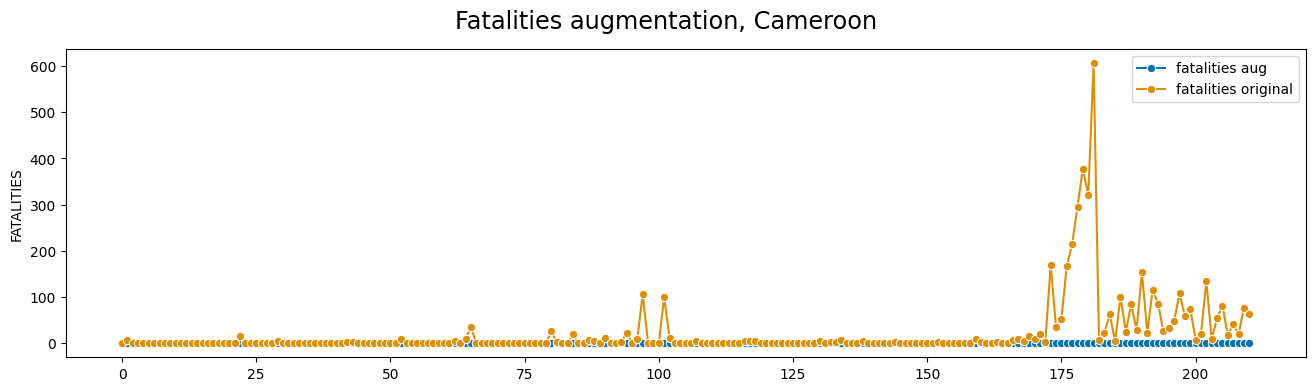

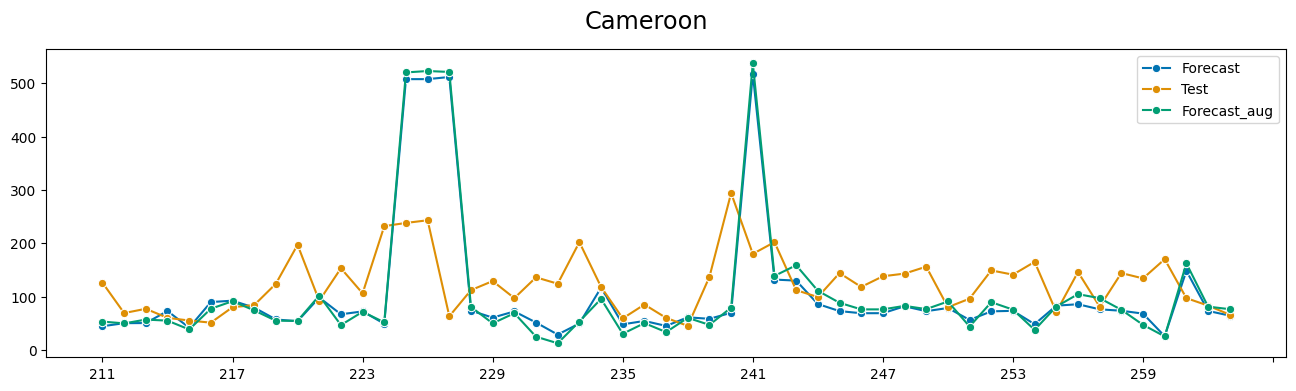

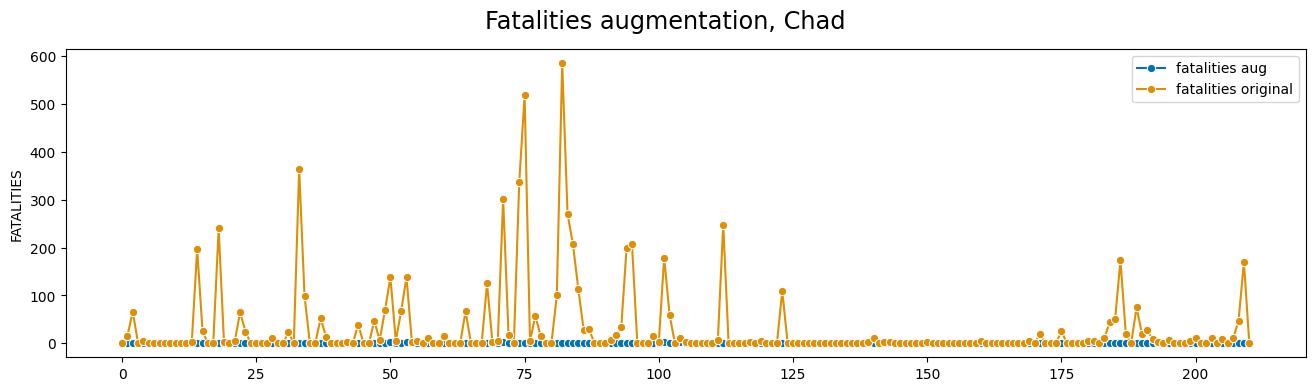

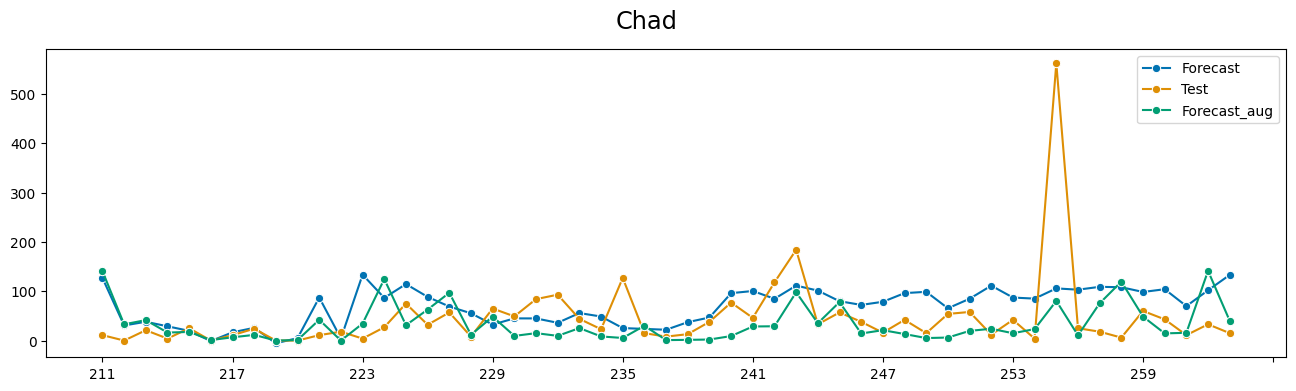

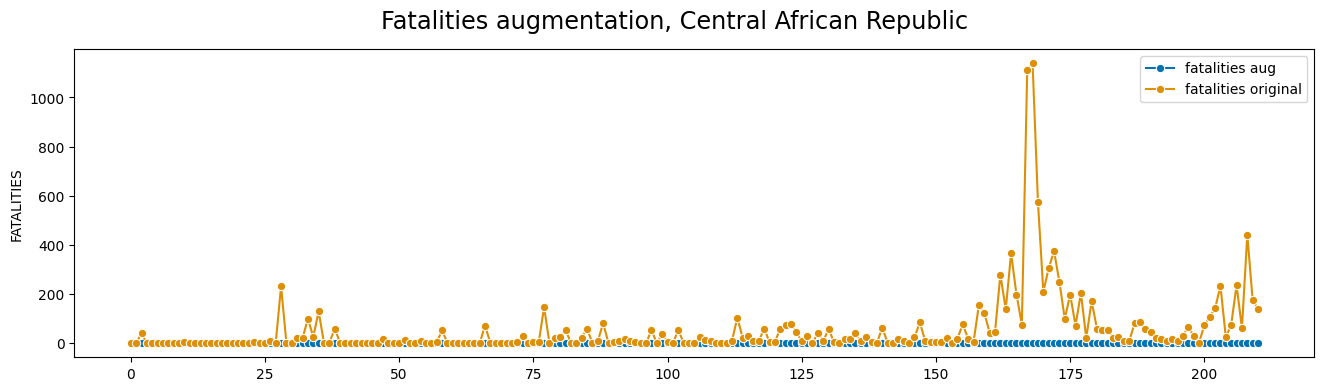

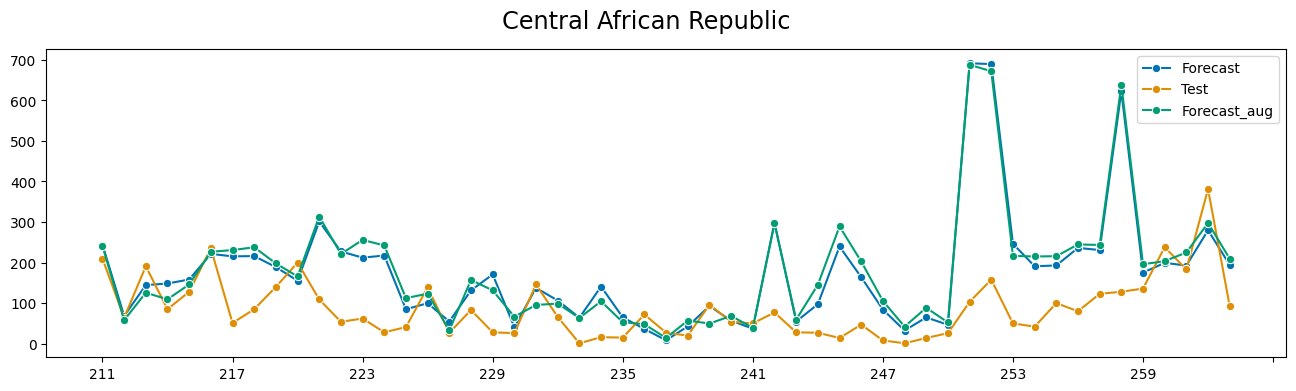

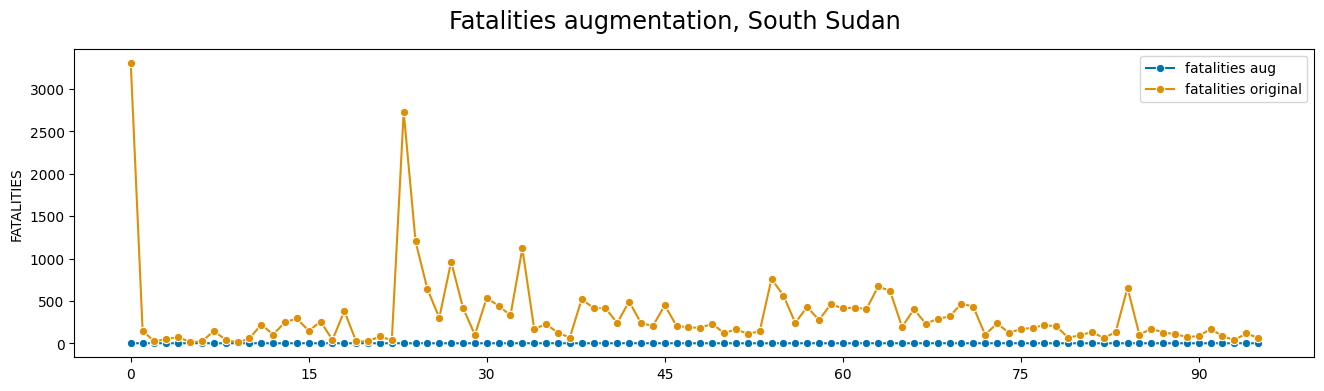

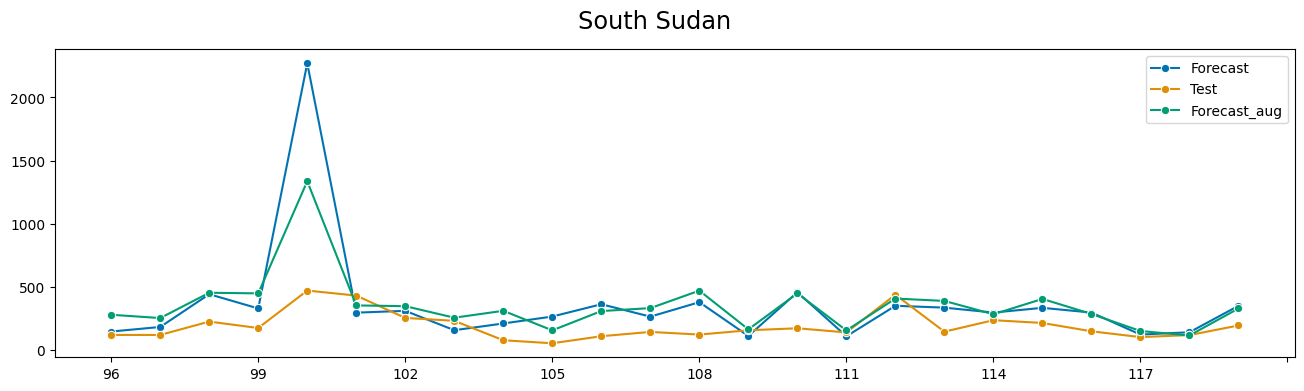

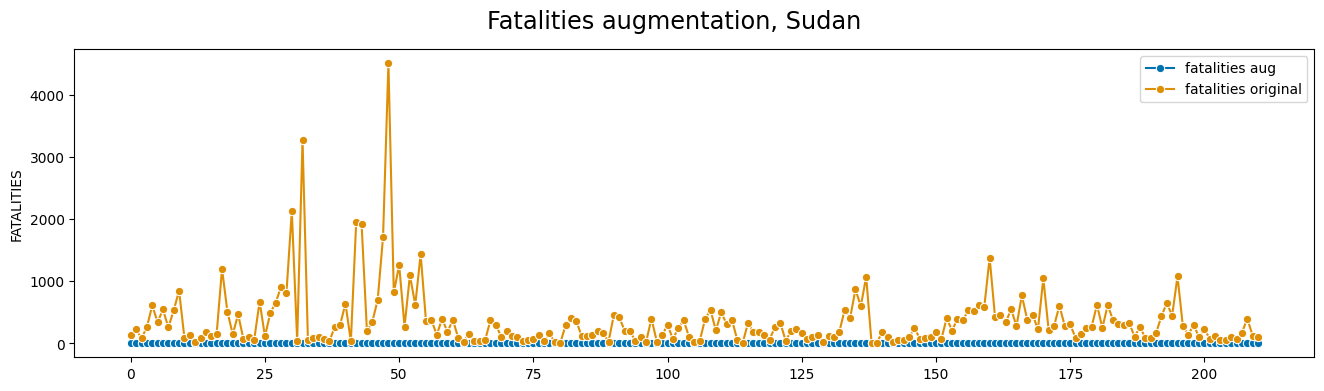

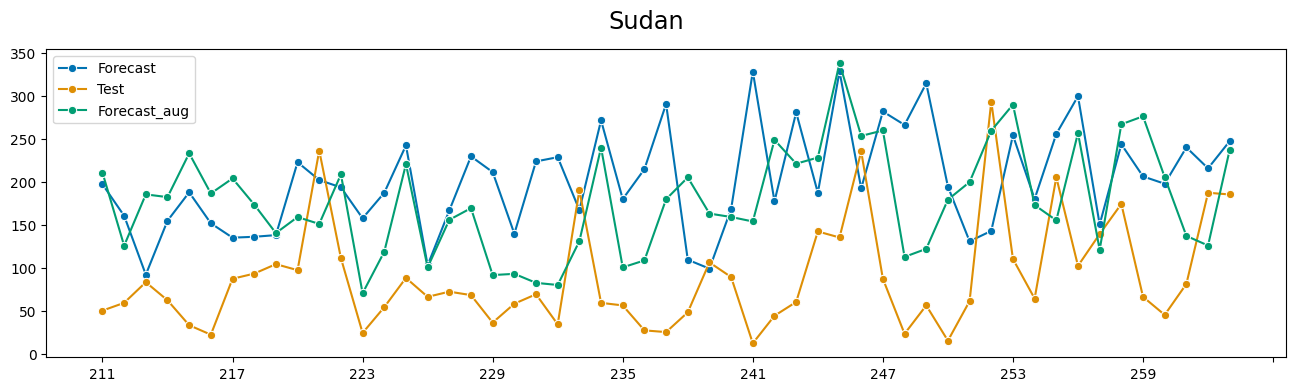

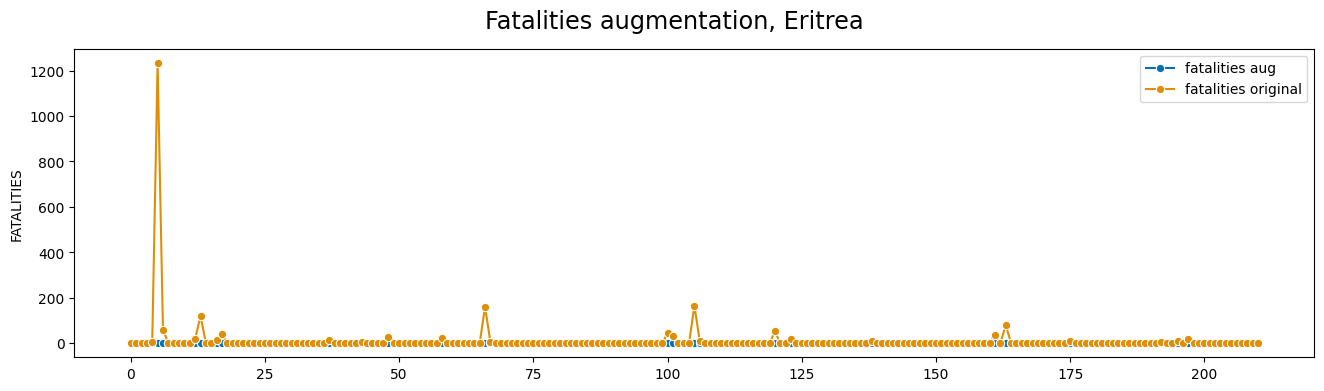

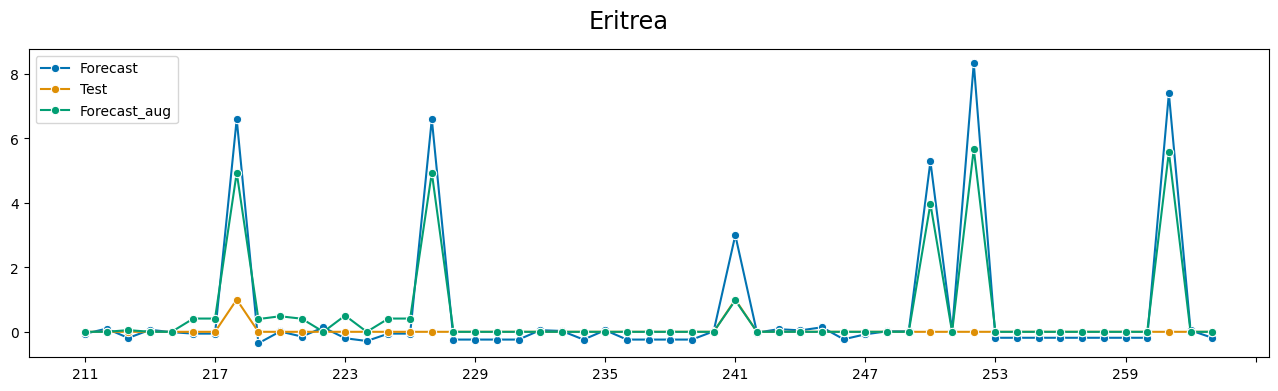

In [ ]:
target = 'FATALITIES'

for cid, country in enumerate(target_countries):
    data = dataset.loc[dataset['COUNTRY'] == country].copy()
    data = data.drop('COUNTRY', axis = 1)
    data = data.drop('MY', axis=1)
    data = data.reset_index(drop=True)

    train, test = temporal_train_test_split(data, test_size=0.20)

    xtrain_original = train.drop(target, axis=1)
    y_train_original = train[target]

    xtest = test.drop(target, axis=1)
    ytest = test[target]

    print(len(train[train[target]<=5]), len(train[train[target]>5]))
    if len(train[train[target]<=5]) == 0:
        data_aug_ab = pd.DataFrame(columns=train.columns)
    else:
        data_aug_ab = kernel.shift_domain(train[train[target]<=5], domain_shifter_ab)
    
    if len(train[train[target]>5]) == 0:
        data_aug_ba = pd.DataFrame(columns=train.columns)
    else:
        data_aug_ba = kernel.shift_domain(train[train[target]>5], domain_shifter_ba)

    data_aug = pd.concat([data_aug_ab, data_aug_ba], axis=0).sort_index()

    data_aug = kernel.shift_domain(train, domain_shifter_ab)

    fatalities_aug = data_aug[target]
    plot_series(fatalities_aug, y_train_original, labels=["fatalities aug","fatalities original"], title='Fatalities augmentation, ' + country)


    data_aug = pd.concat([train, data_aug], axis=0)

    xtrain = data_aug.drop(target, axis=1)
    ytrain = data_aug[target]

    forecaster = xgb.XGBRegressor()
    forecaster.fit(xtrain, ytrain)

    forecaster_original = xgb.XGBRegressor()
    forecaster_original.fit(xtrain_original, y_train_original)

    # Make forecasts for the test set
    y_pred = forecaster.predict(xtest)
    y_pred[y_pred < 0] = 0
    y_pred_original = forecaster_original.predict(xtest)

    # Plot the actual vs. predicted delays
    y_pred = pd.DataFrame(y_pred, index=ytest.index)
    y_pred_original = pd.DataFrame(y_pred_original, index=ytest.index)
    plot_series(y_pred_original, pd.DataFrame(ytest), pd.DataFrame(y_pred), labels=["Forecast","Test", "Forecast_aug"], title=country)
    results.append((mean_absolute_error(ytest, y_pred), mean_absolute_percentage_error(ytest, y_pred)))
    results_original.append((mean_absolute_error(ytest, y_pred_original), mean_absolute_percentage_error(ytest, y_pred_original)))

print(results)
print(results_original)

  0%|          | 0/19 [00:00<?, ?it/s]


ValueError: Shapes (19,), (19,) not compatible                                        
Samples are [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

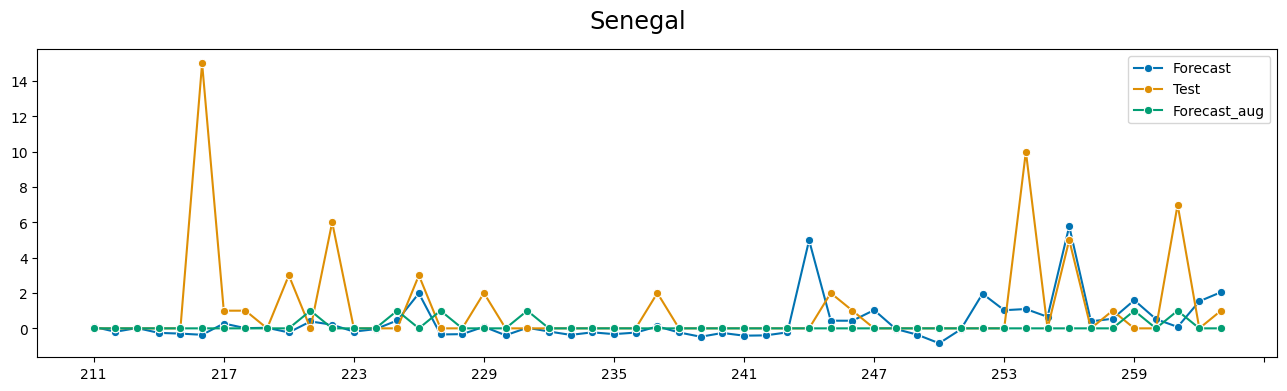

In [ ]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, temporal_train_test_split
from sktime.split import SingleWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sktime.forecasting.base import ForecastingHorizon
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import networkx as nx
from sktime.utils import plot_series
import lingam


def create_forecaster():
    
    regressor = xgb.XGBRegressor()
    forecaster = make_reduction(regressor, window_length=6, strategy='recursive', windows_identical=False)

    return forecaster

country_list = dataset['COUNTRY'].unique()
results = []
results_original = []
window_length = 6

for cid, country in enumerate(target_countries):
    data = dataset.loc[dataset['COUNTRY'] == country].copy()
    data = data.drop('COUNTRY', axis = 1)
    data = data.drop('MY', axis=1)
    data = data.reset_index(drop=True)

    data[target] = data[target].astype(float)
    for lag in range(1, window_length):
        data[f'FATALITIES_lag{lag}'] = data[target].shift(lag).fillna(0).astype(float)

    train, test = temporal_train_test_split(data, test_size=0.20)

    xtrain_original = train.drop(target, axis=1)
    y_train_original = train[target]

    xtest = test.drop(target, axis=1)
    ytest = test[target]

    causal_model = lingam.DirectLiNGAM()
    causal_model.fit(data)

    causal_graph = nx.DiGraph(causal_model.adjacency_matrix_)

    # nx.draw(causal_graph)

    kfs = kernel.get_default_kernel_functions_from_df(train)
    k = kernel.GraphKernel()
    k.fit(data, causal_graph, kernel_coefficients='silverman')

    data_aug, weights = kernel.fast_causal_augmentation(train, causal_graph, k, -1, 0.5, topk=500)
    #TODO: causal data aug should return at least the original data
    #TODO: use causal data aug over shifted data and try with only fatalities

    xtrain = data_aug.drop(target, axis=1)
    ytrain = data_aug[target]

    forecaster = xgb.XGBRegressor()
    forecaster.fit(xtrain, ytrain)

    forecaster_original = xgb.XGBRegressor()
    forecaster_original.fit(xtrain_original, y_train_original)

    # Make forecasts for the test set
    y_pred = forecaster.predict(xtest)
    y_pred_original = forecaster_original.predict(xtest)

    # Plot the actual vs. predicted delays
    y_pred = pd.DataFrame(y_pred, index=ytest.index)
    y_pred_original = pd.DataFrame(y_pred_original, index=ytest.index)
    plot_series(y_pred_original, pd.DataFrame(ytest), pd.DataFrame(y_pred), labels=["Forecast","Test", "Forecast_aug"], title=country)
    results.append((mean_absolute_error(ytest, y_pred), mean_absolute_percentage_error(ytest, y_pred)))
    results_original.append((mean_absolute_error(ytest, y_pred_original), mean_absolute_percentage_error(ytest, y_pred_original)))

print(results)
print(results_original)